In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
#for ipynb
%matplotlib inline

In [2]:
#get list of files with data
in_dir = '../results'
site_group = '.5e-4_qval'
in_files = []
for file in os.listdir(in_dir):
    if not file == 'plots':
        in_files.append(in_dir+'/'+file+'/'+file+'.GC_map_corrected.coverage.tsv')
print(len(in_files))    

254


In [3]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [4]:
#import data
start_time = time.time()
data = pd.DataFrame()
for i,file in enumerate(in_files):
    if i%50==0:
        print(i,'importing',file,time.time()-start_time)
    current = pd.read_csv(file,sep='\t')
    current = current[current['site_name'].str.contains(site_group)]
    data = data.append(current, ignore_index=True)
        

0 importing ../results/MBC_1421_3_ULP/MBC_1421_3_ULP.GC_map_corrected.coverage.tsv 0.0007755756378173828
50 importing ../results/MBC_1167_5_ULP/MBC_1167_5_ULP.GC_map_corrected.coverage.tsv 1.9686973094940186
100 importing ../results/MBC_1297_ULP/MBC_1297_ULP.GC_map_corrected.coverage.tsv 3.566119909286499
150 importing ../results/MBC_1421_5_ULP/MBC_1421_5_ULP.GC_map_corrected.coverage.tsv 5.608529567718506
200 importing ../results/MBC_1117_1_ULP/MBC_1117_1_ULP.GC_map_corrected.coverage.tsv 7.593834400177002
250 importing ../results/MBC_1111_1_ULP/MBC_1111_1_ULP.GC_map_corrected.coverage.tsv 10.053064584732056


In [5]:
#get the subtype data
subtype_data = pd.read_csv('../../../metadata/MBC/merged_tables_revisions1/merged_key_metadata.txt', sep='\t')
metadata_columns = ['sample','patient_id','revisions_ER_status_binary','ulp_wgs_coverage','tumor_fraction','first_passing_sample']
subtype_data = subtype_data[metadata_columns]

#merge with data
print(len(data))
data = data.merge(subtype_data, on = 'sample')
print(len(data['sample'].unique()))


1016
254


In [6]:
data['number_of_sites'].unique()

array([22365,  9930, 18240, 19347])

In [7]:
print(len(data['site_name'].unique()))
data['site_name'].unique()

4


array(['ER_neg_heme.5e-4_qval', 'ER_pos_heme.5e-4_qval',
       'ER_pos_specific.5e-4_qval', 'ER_neg_specific.5e-4_qval'],
      dtype=object)

In [8]:
#reformat for logistic regression
reformatted = data[metadata_columns+['site_name','central_coverage','amplitude','mean_coverage']]
reformatted = reformatted.set_index(metadata_columns+['site_name']).unstack()

new_column_names = []
for item in reformatted.columns.values:
    new_column_names.append('_'.join(item))
    
reformatted.columns = new_column_names

# reformatted.to_csv('reformatted_data_with_features.txt',sep='\t')

In [9]:
site_groups = data['site_name'].str.rsplit('.',1,expand=True)[1].unique()
site_names = data['site_name'].unique()

for item in site_groups:
    current_sites = [m for m in site_names if m.endswith(item)]
    current_features = []

    for sites in current_sites:
        current_features.append('central_coverage_'+sites)
        current_features.append('mean_coverage_'+sites)
        current_features.append('amplitude_'+sites)

    current = reformatted[current_features]
    print(current.shape)
    current.to_csv('correction_test_merged_data/GC_map_corrected_'+item+'_reformatted.txt', sep='\t')


(254, 12)


In [10]:
site_groups

array(['5e-4_qval'], dtype=object)

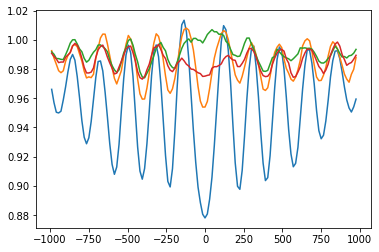

In [11]:
#plot
for site_name in data['site_name'].unique():
    current = data[data['site_name']==site_name][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    
# plt.legend()



fft real -0.4376243633297593
fft imag -0.01890170406444689
fft magn 0.43803237071741297
sum x coords -0.43762436332977217
sum y coords -0.018901704064468394
magnitude: 0.4380323707174268


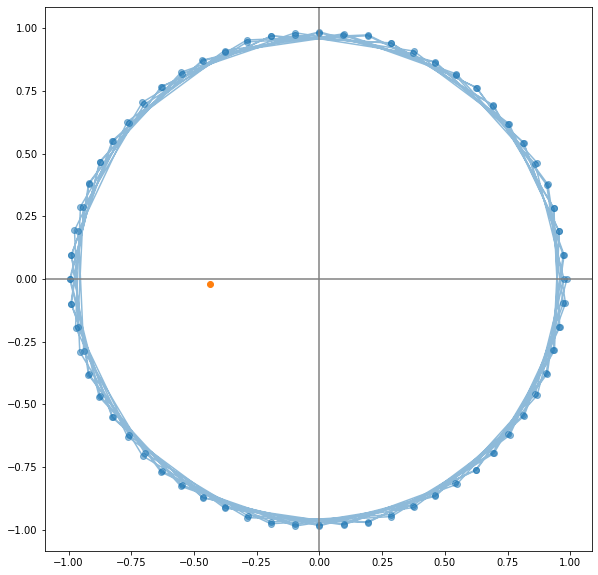

In [12]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [13]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)